# sprint6　　　kmeans法　スクラッチ

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import math
import random
from numpy import linalg

from mpl_toolkits.mplot3d import Axes3D


from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=100, n_features=2, centers=4, cluster_std=0.5, shuffle=True, random_state=0)

# ラベルyを使用しないことを明示するためのアンダースコア＿

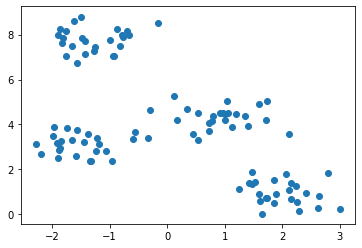

In [2]:
plt.scatter(X[:,0],X[:,1])

In [3]:
class ScratchKMeans():
    """
    n_init : int
      中心点の初期値を何回変えて計算するか
    max_iter : int
      1回の計算で最大何イテレーションするか
    tol : float
      イテレーションを終了する基準となる中心点と重心の許容誤差
    """
    def __init__(self, n_init, max_iter):
        # ハイパーパラメータを属性として記録
        self.n_init = n_init
        self.max_iter = max_iter
    
    def _base_vertex(self,data,k,random_state=1):
    # 乱数シードは原則固定。出力は、基準点k個の座標。
        np.random.seed(seed = random_state)
        select_index = np.random.choice(len(data), k, replace=False)
        k_center = np.array([data[i,:] for i in select_index])        
        return k_center
    
    def allocate(self,data,centers):
        r_nk = np.ones(len(data)*len(centers))
        r_nk = r_nk.reshape(len(data),len(centers))

        #　linalgによるc_number演算（Xの各サンプルに基準点座標をマイナス（ブロードキャスト）したもの）。
        # 　for 文により、r_nk の各列に、各基準点でのlinalg演算結果を記憶させる。
        # 　r_nk の各行（Xのサンプルに対応）にて、最小値（のインデックス）を求める。

        for i in range(len(centers)):
            r_nk[:,i] = linalg.norm(data - centers[i], axis=1)
        r_nk = np.argmin(r_nk,axis=1)
        return r_nk

    def move_vertex(self,data,r_nk):
        # 入力をpd形式にしてgroupbyで平均値を求める。出力はグループ毎の中心座標。
        r_nk = r_nk.reshape(-1,1)
        data1 = np.concatenate([data, r_nk], 1)
        pd_data = pd.DataFrame(data1)
        
        # groupbyで各グループでの平均値を求める（r_nkは2列目）
        data_mean = pd_data.groupby(2).mean()
        data_mean = data_mean.values
        return data_mean
    
    def SSE2(self,data,centers,r_nk):
        # r_nk を0と1の行列に変換（r_nk1）。
        # 100個のサンプル点と基準点（例えば、k=5）とのユーグリッド距離を導出する。dot積の対角行列のみを取り出して基準点数を繰り返し（E_dist）。例えば100行5列の出力）。
        # E_distとr_nk1とのアダマール積の全要素の合計を取る。

        r_nk1 = np.zeros(len(data)*len(centers))
        r_nk1 = r_nk1.reshape(len(data),len(centers))
        count = 0
        for i in r_nk :
            r_nk1[count, i ] = 1 
            count = count + 1
        
        E_dist = np.ones(len(data)*len(centers))
        E_dist = E_dist.reshape(len(centers),len(data))
        for i in range(len(centers)):
            E_dist[i] = np.sqrt(np.diag(np.dot((data-centers[i]), (data-centers[i]).T)))
    
        SSE_temp = sum(sum(E_dist*r_nk1.T))
        return SSE_temp

    def fit(self, data, c_number):

        SSE2_list = []
        for j in range(self.n_init):
            n_clusters = self._base_vertex(data,c_number,random_state = np.random.randint(1000))
            for i in range(self.max_iter):
                r_list = self.allocate(data, n_clusters) 
                n_clusters = self.move_vertex(data,r_list)
            SSE2_list.append(self.SSE2(data, n_clusters, r_list))
            
        # イタレーションにおける最小のSSEを記録。
        self.SSE = np.min(SSE2_list)
               
        # 最小のSSEとなる際の、クラスタ中心座標群を取得（min_n_clusters）。
        for j in range(self.n_init):
            n_clusters = self._base_vertex(data,c_number,np.random.randint(1000))
            for i in range(self.max_iter):
                r_list = self.allocate(data, n_clusters) 
                n_clusters = self.move_vertex(data, r_list)
            if self.SSE2(data, n_clusters, r_list) == self.SSE:
                self.min_n_clusters = n_clusters
                #print(r_list)
                break
        
    def predict(self, data):
        # fit時（SSEが最小となる際の、クラスタ中心座標群によるクラスタ割当結果を出力（p_dist））
        p_dist = np.ones(len(data)*len(self.min_n_clusters))
        p_dist = p_dist.reshape(len(self.min_n_clusters),len(data)) 
        for i in range(len(self.min_n_clusters)):
            p_dist[i] = np.diag(np.dot((data - self.min_n_clusters[i]), (data - self.min_n_clusters[i]).T))
        #print(p_dist)
        p_dist = np.argmin(p_dist,axis=0)
        return p_dist


## 【問題1】中心点の初期値を決める

In [11]:
def kmeans(data,k,random_state=1):
    ### 入力　data:サンプルデータ 　k:クラスタ数。　乱数シード固定
    np.random.seed(seed = random_state)
    select_index = np.random.choice(len(X),k, replace=False)
    k_center = np.array([data[i,:] for i in select_index])
    return k_center

n_clusters =kmeans(X,5)
n_clusters

#print(X[0:3,:])
# print(X[:,:]-n_clusters[0,:])
# print(n_clusters[0,:])
#print(np.diag(np.dot((X-n_clusters[0,:]), (X-n_clusters[0,:]).T)))

array([[ 1.64869438,  0.03452236],
       [ 1.73810647,  0.71629308],
       [ 2.06051753,  1.79059891],
       [-1.61803727,  8.60696731],
       [-1.19075663,  3.12161318]])

## 【問題２】SSEを求める関数の作成

In [12]:
r0 = np.random.choice(len(n_clusters), len(X),replace=True)
r0

array([4, 2, 4, 3, 3, 0, 3, 4, 3, 4, 4, 4, 1, 0, 4, 2, 0, 2, 4, 1, 1, 0,
       2, 4, 4, 0, 4, 1, 4, 1, 0, 2, 3, 1, 2, 4, 4, 2, 2, 0, 1, 2, 2, 0,
       1, 2, 4, 0, 1, 2, 1, 4, 2, 0, 0, 1, 0, 1, 3, 1, 1, 4, 4, 3, 0, 3,
       0, 3, 1, 2, 4, 0, 0, 3, 1, 1, 0, 0, 4, 2, 3, 4, 2, 0, 3, 3, 1, 2,
       4, 3, 0, 0, 4, 2, 4, 2, 0, 3, 0, 0])

In [13]:
def SSE(data,centers, r_nk=None):
    # 入力　data:サンプルデータ　centers:クラスタ配列
    # n_clusters の中から、距離を求める点をランダムで選択する。
    # r0:各サンプルをクラスタにランダムで割り当て
    # r1：onehotな表現のr0を代入する
    if r_nk == None:
        np.random.seed(seed=32)
        r0 = np.random.choice(len(centers), len(data),replace=True)
        r1 = np.zeros(len(data)*len(centers)).reshape(len(centers),len(data))

        # rnkとしてr1を作成。 
        count = 0
        for i in r0 :
            r1[i,count] = 1 
            count = count + 1
    if r_nk != None:
        r_nk1 = np.zeros(len(data)*len(centers)).reshape(len(data),len(centers))
        count = 0
        for i in r_nk :
            r_nk1[count, i ] = 1 
            count = count + 1
    
    E_dist = np.ones(len(centers)*len(data))
    E_dist = E_dist.reshape(len(centers),len(data))
    
    for i in range(len(centers)):
        E_dist[i] = np.diag(np.dot((X-centers[i]), (X-centers[i]).T))
    
#     print(E_dist.shape)
#     print(r1.shape)
#     print(np.dot(r1.T,E_dist))
    return sum(sum(np.dot(r1.T,E_dist)))

SSE(X,n_clusters)

223503.83329654817

## 【問題３】クラスタへの割り当て

In [14]:
from numpy import linalg

def allocate(data,centers):
    r_nk = np.ones(len(data)*len(centers))
    r_nk = r_nk.reshape(len(data),len(centers))

# 　for 文により、r_nk の各列に、各クラスタ基準点でのlinalg演算結果を記憶させる。
#　Xの各サンプルに各クラスタ基準点座標をマイナス（ブロードキャスト）。
# linealg.norm(axis=1)により、各サンプル・各クラスタ基準点座標間の距離を導出。

    for i in range(len(centers)):
        r_nk[:,i] = linalg.norm(data - centers[i], axis=1)

# 　r_decide の各行（Xのサンプルに対応）にて、最小値（のインデックス）を求める。
    r_nk = np.argmin(r_nk,axis=1)
    return r_nk

r_list = allocate(X,n_clusters)
r_list

array([4, 3, 2, 4, 2, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 1, 2, 4, 4, 1, 2, 3,
       4, 0, 4, 4, 4, 4, 2, 1, 1, 3, 1, 2, 4, 2, 3, 2, 3, 4, 4, 4, 3, 4,
       4, 3, 1, 4, 4, 4, 4, 1, 4, 4, 4, 3, 3, 1, 2, 3, 3, 2, 1, 2, 1, 3,
       4, 4, 2, 4, 3, 1, 4, 3, 4, 2, 4, 4, 1, 1, 0, 3, 4, 4, 1, 4, 1, 1,
       2, 4, 4, 4, 4, 4, 4, 3, 3, 4, 3, 4], dtype=int64)

## 【問題4】中心点の移動

In [15]:
def move_vertex(data,r_nk):
    #入力　data：サンプルデータ、r_nk:サンプルデータのクラスタへの割当情報
    #出力　各クラスタの平均座標
    #dataの列方向にr_nk(割り当てられたクラスタ番号)をconcatenateし、groupbyで束ねてクラスタごとに平均値をとる。
 
    r_nk = r_nk.reshape(-1,1)
    data1 = np.concatenate([data, r_nk], 1)
    pd_data = pd.DataFrame(data1)
    data_mean = pd_data.groupby(2).mean()
    data_mean = data_mean.values
    return data_mean

X_mean = move_vertex(X,r_list)
X_mean

array([[ 1.96839656,  0.08203209],
       [ 1.9853056 ,  0.80623831],
       [ 1.79726115,  2.92655116],
       [-1.26811733,  7.76378266],
       [-0.57920747,  3.63146154]])

## 【問題5】繰り返し
## 【問題6】異なる初期値での計算

In [16]:
iter_num = 5   # クラスタ中心点移動の繰り返し回数
n_init = 10    # クラスタ初期値変更の繰り返し回数
k = 4

#　クラスタ中心の初期座標決定の繰り返し
for j in range(n_init):
    n_clusters = kmeans(X,k,np.random.randint(1000))

    # 各サンプルデータのクラスタへの割当と、クラスタ中心座標移動の繰り返し
    for i in range(iter_num):
        r_list = allocate(X,n_clusters) 
        n_clusters = move_vertex(X,r_list)
    
    # r_listをonehot表現（r_nk1）に変換する。
    r_nk1 = np.zeros(len(X)*len(n_clusters))
    r_nk1 = r_nk1.reshape(len(X),len(n_clusters))
    count = 0
    for i in r_list :
        r_nk1[count, i ] = 1 
        count = count + 1

    # 各サンプルデータと各クラスタ中心座標との距離を求める。（E_dist）。
    # onehot表現のr_nk1とアダマール積を取り合計したものを返す。
    E_dist = np.ones(len(X)*len(n_clusters))
    E_dist = E_dist.reshape(len(n_clusters),len(X))
    
    for i in range(len(n_clusters)):
        E_dist[i] = np.sqrt(np.diag(np.dot((X-n_clusters[i]), (X-n_clusters[i]).T)))
        # E_dist[i] = linalg.norm(X - n_clusters[i], axis=1) と同様。

    SSE_temp = sum(sum(E_dist*r_nk1.T))
    print(SSE_temp)


62.63796180120853
126.234395468774
99.80887826409354
100.17984725673536
62.63796180120853
62.63796180120853
62.63796180120853
100.86282914409267
62.63796180120853
99.80887826409354


## 【問題７】　推定

In [17]:
clf = ScratchKMeans(10,10)
clf.fit(X,4)
clf.predict(X)

array([3, 2, 3, 3, 3, 3, 1, 2, 3, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 0, 3, 2,
       1, 0, 3, 1, 1, 3, 0, 0, 0, 2, 0, 0, 1, 3, 2, 0, 2, 1, 3, 1, 2, 1,
       1, 2, 0, 1, 3, 3, 3, 0, 1, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 3, 0, 2,
       1, 1, 0, 3, 2, 0, 3, 2, 3, 3, 1, 1, 0, 0, 0, 2, 1, 3, 0, 1, 0, 0,
       3, 3, 3, 1, 3, 1, 1, 2, 2, 1, 2, 3], dtype=int64)

## 【問題８】　エルボー法

In [18]:
def elbow(data,c_number_max):
    SSE_list = np.zeros(c_number_max)
    for i in range(1,c_number_max):
        clf.fit(data,i)
        SSE_list[i] = clf.SSE
    return SSE_list

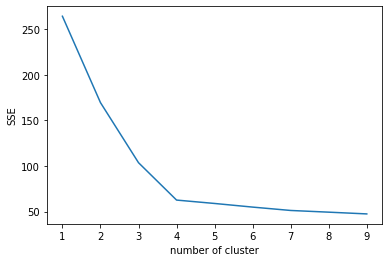

In [19]:
SSE_list = elbow(X,10)
plt.plot(range(1,10),SSE_list[1:10])
plt.xlabel("number of cluster")
plt.ylabel("SSE")
plt.show()

## 【問題１０】クラスタ数ｋの選択

卸売業者のデータ分析

クラスタリングを利用法を学ぶために、Wholesale customers Data Setを使用します。

UCI Machine Learning Repository: Wholesale customers Data Set

Data Folderの中からWholesale customers data.csvをダウンロードしてください。これはポルトガルのリスボンにある卸売業者（wholesale）が顧客から集めたデータです。中身は各顧客が年間でミルクや食料品を何ユーロ購入しているかというデータになっています。顧客は小売店やレストランです。RegionとChannelは取り覗き、金額のデータでK-meansを利用します。

In [20]:
import pandas as pd
wc_data = pd.read_csv("WCdata.csv")
wc_data1 = wc_data.iloc[:,2:]

In [21]:
wc_data1

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...
435,29703,12051,16027,13135,182,2204
436,39228,1431,764,4510,93,2346
437,14531,15488,30243,437,14841,1867
438,10290,1981,2232,1038,168,2125


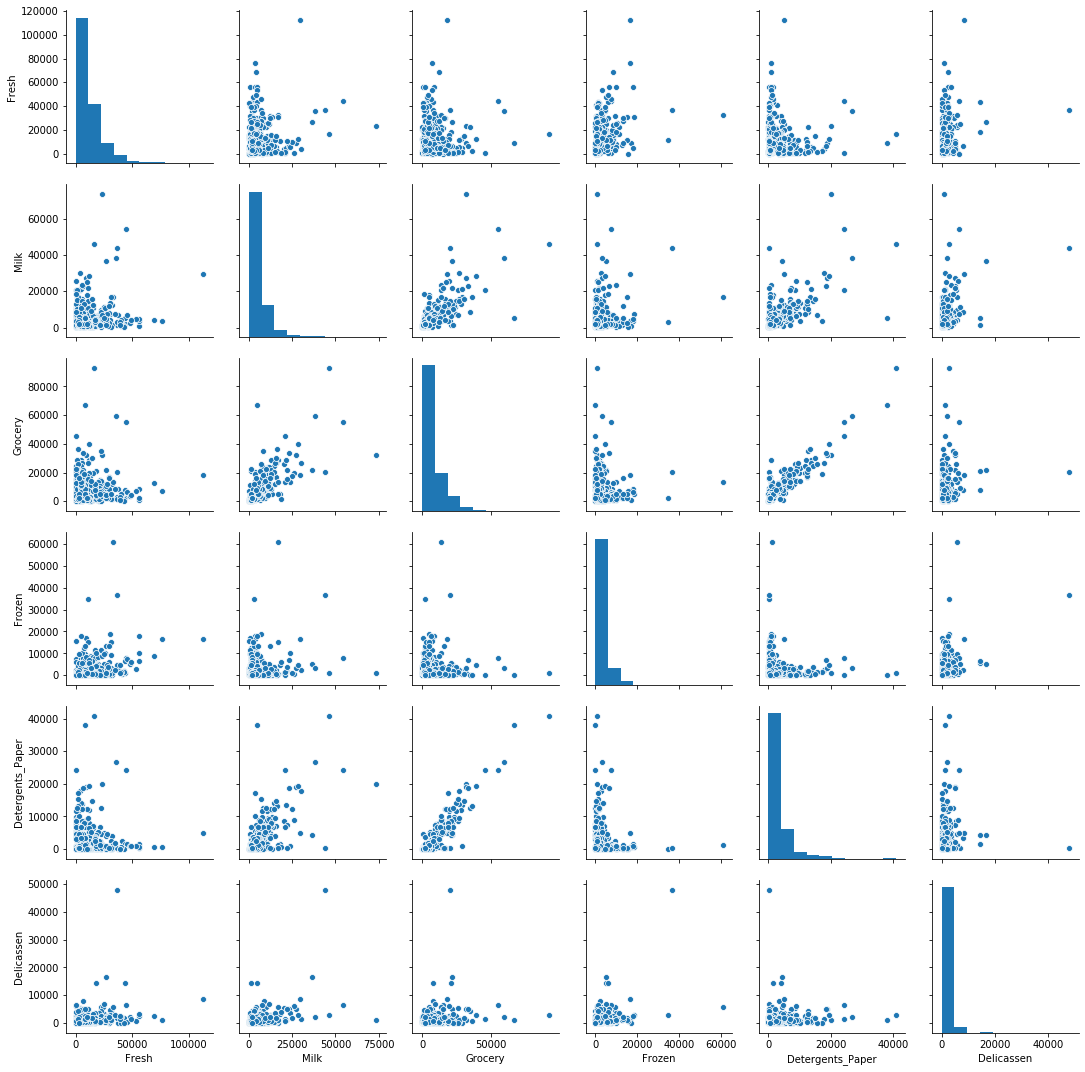

In [91]:
sns.pairplot(wc_data1)

In [22]:
# 主成分＝2(n_components=2)の場合
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
pca = pca.fit(wc_data1)
data_pca = pca.transform(wc_data1)

[0.45961362 0.86478588 0.93481597 0.97883941 0.99386152 1.        ]


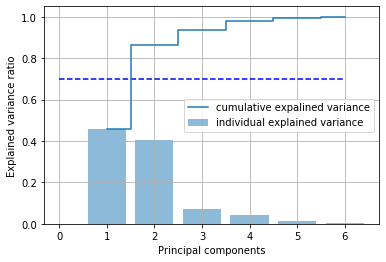

In [23]:
# 主成分＝6　(n_components=6)の場合
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=6)
pca = pca.fit(wc_data1)
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(cum_var_exp)
plt.bar(range(1,7), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,7), cum_var_exp, where='mid', label='cumulative expalined variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.hlines(0.7, 0, 6,  "blue", linestyles='dashed')
plt.legend(loc='best')
plt.grid()
plt.show()

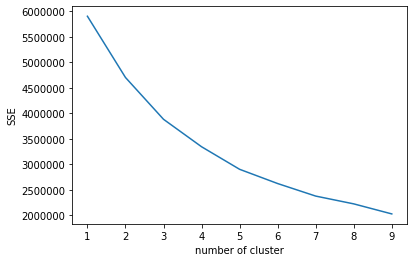

In [24]:
SSE_list = elbow(data_pca,10)
plt.plot(range(1,10), SSE_list[1:10])
plt.xlabel("number of cluster")
plt.ylabel("SSE")
plt.show()

＜考察＞  
エルボー曲線からは、３又は４ぐらいのクラスタ数が適切であるものと思われる。
（また分散説明率のグラフからは、２つの要素（Fresh,milk）で８割を超過することから考慮して２×２の４ぐらいのクラスタ数が適切なようにも思われる。）

## 【問題11】既知のグループとの比較

In [17]:
#　RegionとChannelをデータから抽出。
wc_data2 = wc_data.iloc[:,0:2]
# data_pca：6次元から2次元に削減されたデータ
pd_data_pca = pd.DataFrame(data_pca, columns=["pca_1d","pca_2d"])
# wc_data2は、regionやchannelの散布図をみるためのＤＦ
wc_data2  = pd.concat([wc_data2,pd_data_pca],axis=1)


In [18]:
clf = ScratchKMeans(10,10)
clf.fit(data_pca,4)
cluster = clf.predict(data_pca)
# wc_data2は、kmeansで4分類された散布図をみるためのＤＦ
wc_cluster = pd.DataFrame(cluster,columns=["kmeans_class"])
wc_cluster = pd.concat([pd_data_pca,wc_cluster],axis=1) 

In [19]:
ksample1 = wc_cluster.query("kmeans_class == 0")
ksample2 = wc_cluster.query("kmeans_class == 1")
ksample3 = wc_cluster.query("kmeans_class == 2")
ksample4 = wc_cluster.query("kmeans_class == 3")

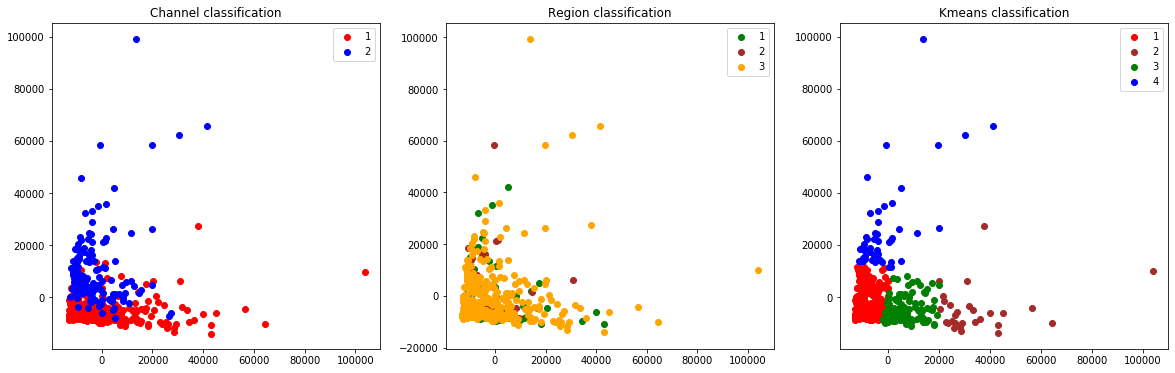

In [20]:
sample1 = wc_data2.query("Channel == 1")
sample2 = wc_data2.query("Channel == 2")
sample3 = wc_data2.query("Region == 1")
sample4 = wc_data2.query("Region == 2")
sample5 = wc_data2.query("Region == 3")

plt.figure(figsize=(20, 6))
plt.subplot(1,3,1)
plt.title("Channel classification")
plt.scatter(sample1.pca_1d,  sample1.pca_2d,  color='red', label="1")
plt.scatter(sample2.pca_1d,  sample2.pca_2d,  color='blue', label="2")
plt.legend()

plt.subplot(1,3,2)
plt.title("Region classification")
plt.scatter(sample3.pca_1d,  sample3.pca_2d,  color='green', label="1")
plt.scatter(sample4.pca_1d,  sample4.pca_2d,  color='brown', label="2")
plt.scatter(sample5.pca_1d,  sample5.pca_2d,  color='orange', label="3")
plt.legend()

plt.subplot(1,3,3)
plt.title("Kmeans classification")
plt.scatter(ksample1.pca_1d,  ksample1.pca_2d,  color='red', label="1")
plt.scatter(ksample2.pca_1d,  ksample2.pca_2d,  color='brown', label="2")
plt.scatter(ksample3.pca_1d,  ksample3.pca_2d,  color='green', label="3")
plt.scatter(ksample4.pca_1d,  ksample4.pca_2d,  color='blue', label="4")
plt.legend()

plt.show()


＜考察＞
channelでは、２つのグループに比較的クラスタリングできているが、regionでは、あまりうまくクラスタリングできていないように思われる。
kmeansは、2つの主成分に次元削減されたデータを、うまくクラスタリングできているように思われる。 

##  k=6 でも分類してみる。（参考）

In [21]:
clf = ScratchKMeans(10,10)
clf.fit(data_pca,6)
cluster = clf.predict(data_pca)
# wc_data2は、kmeansで6分類された散布図をみるためのＤＦ
wc_cluster = pd.DataFrame(cluster,columns=["kmeans_class"])
wc_cluster = pd.concat([pd_data_pca,wc_cluster],axis=1) 

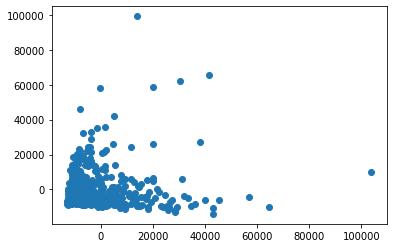

In [22]:
plt.scatter(wc_cluster.pca_1d,wc_cluster.pca_2d)

In [24]:
ksample61 = wc_cluster.query("kmeans_class == 0")
ksample62 = wc_cluster.query("kmeans_class == 1")
ksample63 = wc_cluster.query("kmeans_class == 2")
ksample64 = wc_cluster.query("kmeans_class == 3")
ksample65 = wc_cluster.query("kmeans_class == 4")
ksample66 = wc_cluster.query("kmeans_class == 5")

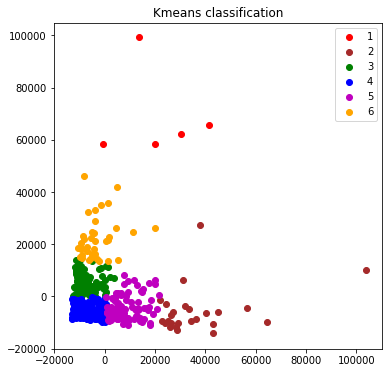

In [25]:
plt.figure(figsize=(20, 6))
plt.subplot(1,3,3)
plt.title("Kmeans classification")
plt.scatter(ksample61.pca_1d,  ksample61.pca_2d,  color='red', label="1")
plt.scatter(ksample62.pca_1d,  ksample62.pca_2d,  color='brown', label="2")
plt.scatter(ksample63.pca_1d,  ksample63.pca_2d,  color='green', label="3")
plt.scatter(ksample64.pca_1d,  ksample64.pca_2d,  color='blue', label="4")
plt.scatter(ksample65.pca_1d,  ksample65.pca_2d,  color='m', label="5")
plt.scatter(ksample66.pca_1d,  ksample66.pca_2d,  color='orange', label="6")
plt.legend()

plt.show()

## 【問題12】卸売業者にとって有益な情報

In [35]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
swc_data = wc_data
swc_data.iloc[:,2:] = sc.fit_transform(swc_data.iloc[:,2:])
wc_data1.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [36]:
temp = wc_data.query("Channel==1")
temp.groupby("Region").mean()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1.0,1.0,0.071411,-0.261230,-0.413574,0.011406,-0.405518,-0.116394
2.0,1.0,-0.027725,-0.473633,-0.374512,0.551270,-0.503906,-0.148682
3.0,1.0,0.148682,-0.313232,-0.428223,0.120667,-0.439941,-0.002323


・チャンネル１では、Milk、Grocery、Detergent_Paperが平均より少なく、Frozenが若干多い傾向

In [37]:
temp = wc_data.query("Channel==2")
temp.groupby("Region").mean()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Region,,,,,,,
1.0,2.0,-0.538574,0.676758,1.108398,-0.100647,1.122070,0.123169
2.0,2.0,-0.373047,0.460449,0.882324,-0.315918,1.161133,-0.101501
3.0,2.0,-0.171631,0.703125,0.843262,-0.321533,0.843750,0.106995


・チャネル２では、Detergents_Paper、Grocery、Milkが多く、Frozen、Freshが少ない傾向。

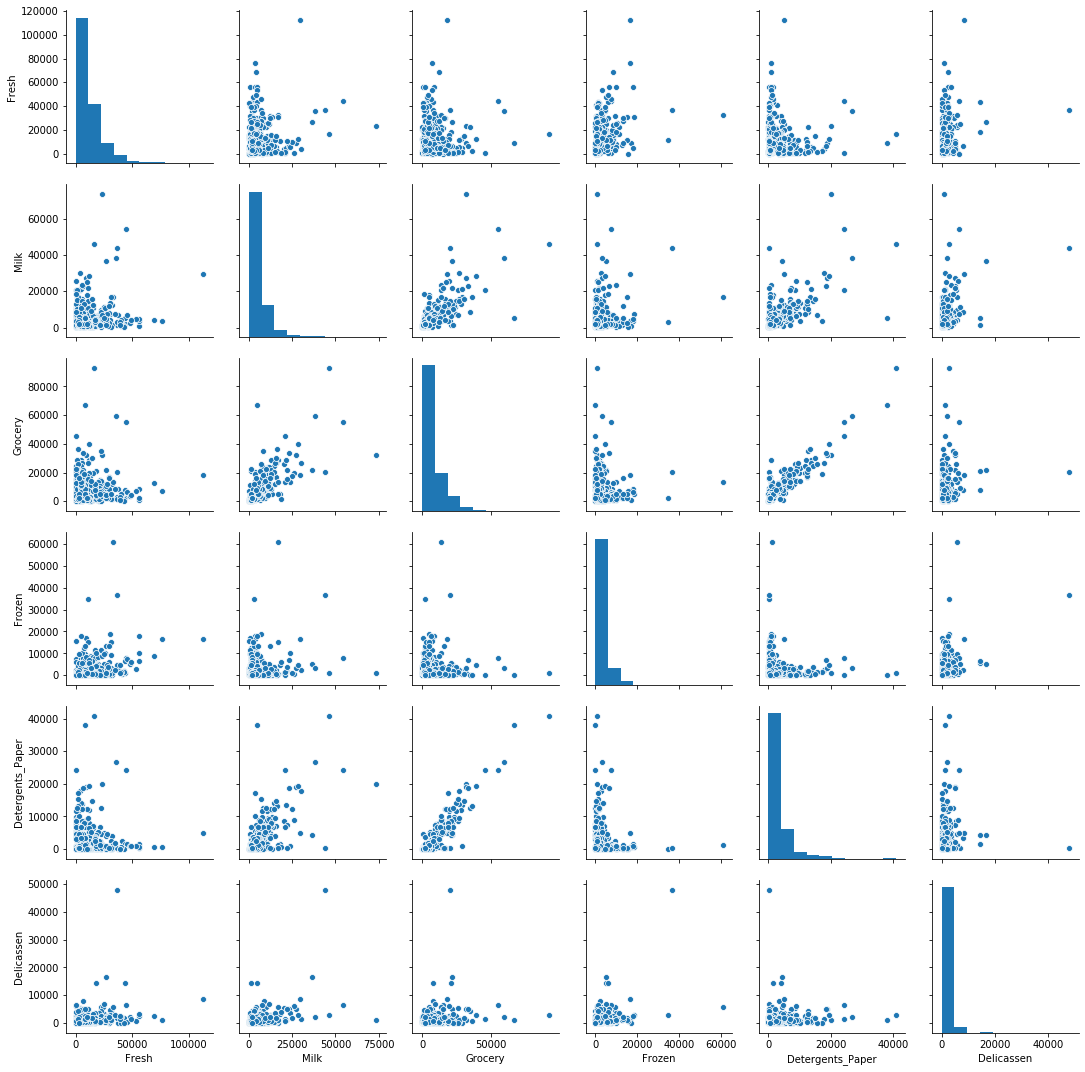

In [167]:
sns.pairplot(wc_data.iloc[:,2:])

・洗剤紙と食料品の相関が高い。これらとMilkも相関性がありそう。  
・デリカッセンと相関性が高いものはない。  
・Freshの購入者は、デリカッセンの購入量は少ない。またFreshを多く購入する者は、groceryやmilkを少なく購入する傾向（負の相関）がありそう。   
・以上から、GroceryとFreshを見ることで購買者の傾向が判断できそう。実際にチャネル１では、groceryよりもfreshが嗜好され、チャネル２では、FreshよりもGroceryが嗜好される。

## 【問題13】（アドバンス課題）他の手法の調査

・ｔ‐ＳＮＥ(t分布型確率的近傍埋め込み法）  
　PCAやMDSが不得手な非線形構造をもつデータの可視化に有効。  
ただし、2次元または3次元への圧縮以外はうまく行くことが保証されておらず、  
高次元で分散が大きいデータのような場合には次元の呪いの影響を受けやすい。また、最適化アルゴリズムの収束性が保証されていない。


・DBSCAN（密度準拠クラスタリングのアルゴリズム）  
半径以内に点がいくつあるかでその領域をクラスタとして判断する。k-meansと違って，最初にクラスタ数を決めなくてもクラスターを作成でき、とがったクラスターでも分類可能。しかしながらborder点の概念が微妙で，データによりどのクラスタに属するか変わる可能性がある。
　  

・ＬＬＥ（LocallyLinearEmbedding）については省略。

## 【問題14】（アドバンス課題）t-SNEとDBSCANの利用

In [56]:
from sklearn.manifold import TSNE
wc_embedded = TSNE(n_components=2).fit_transform(swc_data.iloc[:,2:])
wc_embedded.shape

(440, 2)

In [57]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1, min_samples=4).fit(wc_embedded)
clustering.labels_


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, 15, -1, 16, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1,  2,  3, -1, -1,  7, -1,  1, -1, 15, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  4, -1,  5, -1, -1, -1,  6, -1,
       -1, -1, -1, -1, -1, -1, -1,  7, -1,  3, -1, -1,  8,  8, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 11, -1, -1, -1, -1,
       -1, 11, -1, -1, -1, -1, -1,  9, -1, -1,  2, -1,  8,  1, -1, -1, 10,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  5, 11,
       -1,  8, -1, -1, 11, 12, -1, -1, -1, -1,  4, -1, -1, -1, -1, 10, -1,
       -1, -1, -1, -1, -1, -1, 14, -1, -1, -1, -1, -1,  3, -1, -1, -1, 16,
       -1, -1, -1, -1,  1, 10, -1, -1, -1, -1, 12, -1, -1, -1,  4, -1,  8,
       -1, -1, 10, -1, -1, -1, -1,  7, -1, -1, -1, -1, -1, 11, -1, -1, -1,
       -1, -1, -1, 10, -1

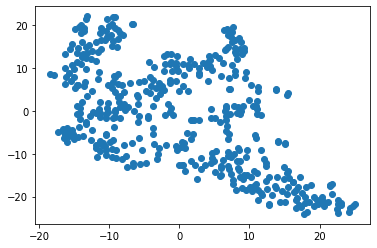

In [46]:
plt.scatter(wc_embedded[:,0],wc_embedded[:,1])

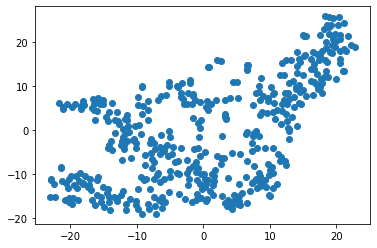

In [58]:
plt.scatter(wc_embedded[:,0],wc_embedded[:,1])

＜メモ＞
　ｔ－ＳＮＥは実行するごとに２次元圧縮の状態が変動するようなので、使いにくいかもしれない。
 　ＤＢＳＣＡＮはパラメータの設定が難しく、６等分に近いようなそれなりの分類を出力することが困難だった。

！ＰＣＡでは、データの標準化が必須。標準化をしてもうまくいかないときは対数化をする。

参考：https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py